<a href="https://colab.research.google.com/github/diazariana/CH_DataScience/blob/main/Properties_Argentina_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🏡 Properties in Capital Federal, Buenos Aires, Argentina - EDA 📊**
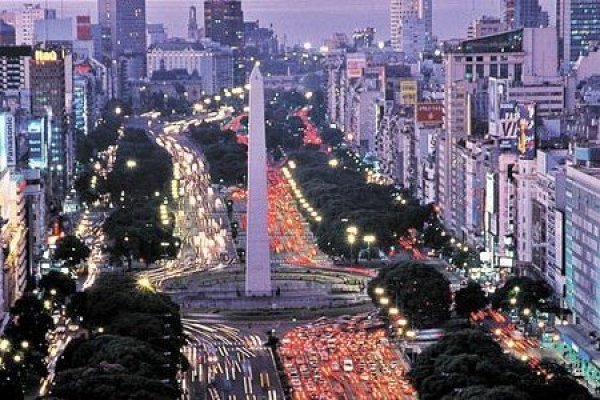


Introduction
This dataset contains 2 millions homes for sale in Argentina. 
The data in this dataset was collected by Properati.

Columns
* id - Notice identifier. It is not unique: if the notification is updated by the real estate agency (new version of the notification) a new record is created with the same id but different dates: registration and cancellation.

* operation_type - Type of operation (these are all sales, can be removed).

* l2 - Administrative level 2: province

* l3 - Administrative level 3: city (In Capital Federal, neighborhood)

* lat - Latitude.

* lon - Longitude.

* price - Price published in the ad (usually USD).

* property_type - Type of property (House, Apartment, PH).

* rooms - Number of rooms (useful in Argentina).

* bathrooms - Number of bathrooms.

* start_date - Date when the ad was created.

* end_date - Date of termination of the advertisement.

* created_on - Date when the first version of the notice was created.

* surface_total - Total area in m².

* surface_covered - Covered area in m².

* title - Title of the advertisement.

* description - Description of the advertisement.

* ad_type - Type of ad (Property, Development/Project).



**Context**
This last few years, there are less properties on sale, and less people buying properties too.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from google.colab import drive
import os
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Python/Propiedades arg/'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Python/Propiedades arg


In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import seaborn as sns
sns.set_theme()
sns.set_palette('Set2')

In [ ]:
data = pd.read_csv('ar_properties_crude.csv')
data.tail(3)

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
999997,tzCbl93/15MUchpCdTNAVQ==,Propiedad,2020-04-29,2020-04-29,2020-04-29,-38.009159,-57.543518,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,...,10.0,NaN,NaN,1200000.0,USD,Mensual,"Imponente Hotel, con 40 habitaciones. Zona Pas...",Hotel en 3 Plantas. Ubicado en calle Falucho ...,Otro,Venta
999998,NAXFObGrH7ffqCRMERy/4Q==,Propiedad,2020-04-29,2020-04-29,2020-04-29,-38.009581,-57.548061,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,...,10.0,NaN,NaN,1100000.0,USD,Mensual,Hotel en impecable estado. Zona Vieja Terminal...,"Hotel en 3 plantas, en excelente estado, con 3...",Otro,Venta
999999,1giQKzrw0ieTlHLaf82gPw==,Propiedad,2020-04-29,2020-06-01,2020-04-29,-38.010714,-57.544685,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,...,10.0,NaN,NaN,400000.0,USD,NaN,Hotel a reciclar. Zona Paseo Aldrey,"Sobre lote propio de 11x20m2. Distrito C2, ha...",Otro,Venta


In [ ]:
data.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object')

In [ ]:
data.shape

(1000000, 25)

In [ ]:
data["ad_type"].value_counts().head(5)

Propiedad    1000000
Name: ad_type, dtype: int64

In [ ]:
data["property_type"].value_counts().head(5)

Departamento       381920
Otro               240860
Casa               179489
Lote                81862
Local comercial     35947
Name: property_type, dtype: int64

In [ ]:
#Checking for null values
data.isnull().sum()

id                       0
ad_type                  0
start_date               0
end_date                 0
created_on               0
lat                 149665
lon                 150962
l1                       0
l2                       0
l3                   59851
l4                  772865
l5                  995546
l6                 1000000
rooms               489446
bedrooms            623864
bathrooms           220403
surface_total       520093
surface_covered     544229
price                47140
currency             50070
price_period        610318
title                   28
description             23
property_type            0
operation_type           0
dtype: int64

In [ ]:
#Drop columns that are not relevant in this analysis
df=data.copy()
df= df.drop('id', axis=1)
df= df.drop(df.columns[9:12], axis=1)
df= df.drop(df.columns[16:19], axis=1)
df= df.drop(['start_date', 'end_date', 'created_on'], axis=1)

In [ ]:
#We select properties on sale in Capital Federal, which surface, price, bedrooms and rooms are not null.
#Also, currency must be in USD. Because of inflation in Argentina prices in ARS are outdated very fast.
def remove_unused_categories(data):
    for cname in data:
        col = data[cname]
        if pd.api.types.is_categorical_dtype(col):
            data[cname] = col.cat.remove_unused_categories()
    return data

clean = np.where(
    (df["surface_total"] > 0) &  
    (df["surface_covered"] > 0) &
    (df["price"] > 0) & 
    (df["l1"] =="Argentina") &
    (df["l2"] =="Capital Federal") &
    (df["operation_type"]=="Venta") &
    (df["ad_type"]=="Propiedad") &
    (df["currency"]=="USD") &
    ((df["property_type"]=="Casa") | (df["property_type"]=="Departmento") | (df["property_type"]=="Otro")) &
    #We are not including Lotes
    (df["bedrooms"] > 0) &
    (df["rooms"] > 0) 
                )
data_clean= df.iloc[clean].copy()
print(data_clean.shape)
data_clean = data_clean.dropna(subset=["l3"])
remove_unused_categories(data_clean)
data_clean.head(5)

(1888, 15)


,ad_type,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,property_type,operation_type
167,Propiedad,-34.568037,-58.466309,Argentina,Capital Federal,Belgrano,6.0,4.0,3.0,238.0,218.0,379000.0,USD,Casa,Venta
169,Propiedad,-34.624318,-58.524317,Argentina,Capital Federal,Versalles,4.0,2.0,1.0,155.0,129.0,190000.0,USD,Casa,Venta
1264,Propiedad,-34.566905,-58.441981,Argentina,Capital Federal,Palermo,3.0,2.0,1.0,116.0,78.0,75000.0,USD,Casa,Venta
1271,Propiedad,-34.569642,-58.494324,Argentina,Capital Federal,Villa Urquiza,3.0,2.0,2.0,182.0,193.0,375000.0,USD,Casa,Venta
1363,Propiedad,-34.656999,-58.425506,Argentina,Capital Federal,Pompeya,4.0,3.0,1.0,99.0,139.0,120000.0,USD,Casa,Venta


In [ ]:
#To create a map I will need coordenates, so i will use this data set:
def remove_unused_categories(data):
    for cname in data:
        col = data[cname]
        if pd.api.types.is_categorical_dtype(col):
            data[cname] = col.cat.remove_unused_categories()
    return data

clean = np.where(
    (data_clean["lat"] < 0) &  
    (data_clean["lon"] < 0)  
                )
df_coord= data_clean.iloc[clean].copy()
remove_unused_categories(df_coord)
df_coord = df_coord.dropna(subset=["lat"])
df_coord = df_coord.dropna(subset=["lon"])

In [ ]:
b=data_clean["l3"].value_counts()
b

Villa Devoto           137
Flores                 119
Belgrano                98
Caballito               95
Mataderos               81
Palermo                 70
Villa Urquiza           63
Floresta                59
Liniers                 57
Parque Chacabuco        57
Villa Luro              56
Saavedra                54
Villa del Parque        52
Villa Pueyrredón        50
Nuñez                   48
Villa Lugano            41
Colegiales              41
Paternal                38
Barracas                38
Versalles               35
Monte Castro            33
Pompeya                 33
Parque Patricios        30
Boedo                   30
Parque Avellaneda       29
Villa Crespo            29
Almagro                 28
Coghlan                 26
Villa General Mitre     26
Recoleta                24
San Cristobal           22
Villa Ortuzar           22
Balvanera               21
Villa Santa Rita        20
Boca                    20
Villa Real              17
Chacarita               17
V

In [ ]:
#All items in l3 represent neighborhoods, except Barrio Norte, which real name is Recoleta.
data_clean=data_clean.replace(to_replace='Barrio Norte', value='Recoleta')

In [ ]:
#Dropping columns that are no longer relevant
data_clean= data_clean.drop(data_clean.columns[0], axis=1)
data_clean= data_clean.drop(data_clean.columns[11], axis=1)
data_clean= data_clean.drop(data_clean.columns[2:4], axis=1)
data_clean= data_clean.drop(data_clean.columns[10], axis=1)
data_clean.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
167,-34.568037,-58.466309,Belgrano,6.0,4.0,3.0,238.0,218.0,379000.0,Casa
169,-34.624318,-58.524317,Versalles,4.0,2.0,1.0,155.0,129.0,190000.0,Casa
1264,-34.566905,-58.441981,Palermo,3.0,2.0,1.0,116.0,78.0,75000.0,Casa
1271,-34.569642,-58.494324,Villa Urquiza,3.0,2.0,2.0,182.0,193.0,375000.0,Casa
1363,-34.656999,-58.425506,Pompeya,4.0,3.0,1.0,99.0,139.0,120000.0,Casa


In [ ]:
#For l3 (NEIGHBORHOOD) Encode with value between 0 and n_classes-1. Same for property_type
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data_clean2=data_clean.copy()
data_clean2['l3'] = labelencoder.fit_transform(data_clean['l3'])
data_clean2['property_type'] = labelencoder.fit_transform(data_clean['property_type'])
data_clean2

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
167,-34.568037,-58.466309,5,6.0,4.0,3.0,238.0,218.0,379000.0,0
169,-34.624318,-58.524317,37,4.0,2.0,1.0,155.0,129.0,190000.0,0
1264,-34.566905,-58.441981,21,3.0,2.0,1.0,116.0,78.0,75000.0,0
1271,-34.569642,-58.494324,49,3.0,2.0,2.0,182.0,193.0,375000.0,0
1363,-34.656999,-58.425506,28,4.0,3.0,1.0,99.0,139.0,120000.0,0
...,...,...,...,...,...,...,...,...,...,...
989406,-34.548636,-58.451351,20,4.0,3.0,2.0,374.0,345.0,760000.0,0
989497,-34.646424,-58.468678,22,4.0,3.0,2.0,360.0,240.0,370000.0,0
990341,-34.573104,-58.448295,11,5.0,4.0,3.0,250.0,250.0,690000.0,0
990362,-34.605546,-58.498080,50,5.0,4.0,3.0,202.0,135.0,339000.0,0


In [ ]:
!pip install folium

In [ ]:
df_coord.dtypes

ad_type             object
lat                float64
lon                float64
l1                  object
l2                  object
l3                  object
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price              float64
currency            object
property_type       object
operation_type      object
dtype: object

In [ ]:
df_coord=df_coord.drop(df_coord.columns[0], axis=1)
df_coord=df_coord.drop(df_coord.columns[2:14], axis=1)
df_coord['new'] = 1
df_coord

,lat,lon,new
167,-34.568037,-58.466309,1
169,-34.624318,-58.524317,1
1264,-34.566905,-58.441981,1
1271,-34.569642,-58.494324,1
1363,-34.656999,-58.425506,1
...,...,...,...
989406,-34.548636,-58.451351,1
989497,-34.646424,-58.468678,1
990341,-34.573104,-58.448295,1
990362,-34.605546,-58.498080,1


In [ ]:
import folium
from folium import Marker
from folium.plugins import HeatMap
import sys
max_amount = float(df_coord['new'].max())

In [ ]:
folium_hmap = folium.Map(location=[-34.57,-58.46],
                        zoom_start=13,
                        tiles="OpenStreetMap")
hm_wide = HeatMap( list(zip(df_coord['lat'], df_coord['lon'], df_coord['new'])),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=12, blur=6,
                   max_zoom=15,
                 )
folium_hmap.add_child(hm_wide)

# **Neighborhood analysis** 🏙

In [ ]:
#Top 5 Neighborhoods with more properties
b=data_clean["l3"].value_counts().head(5)
b=pd.DataFrame(b)

Text(0, 0.5, 'Properties')

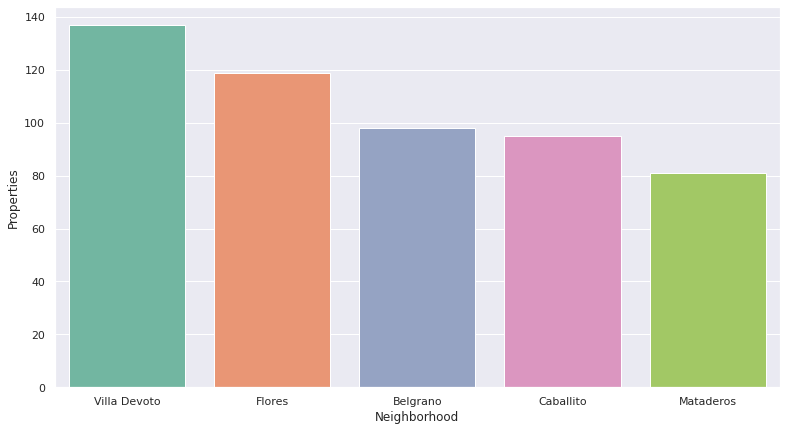

In [ ]:
fig, ax=plt.subplots(figsize =(13, 7))
sns.barplot(x=b.index,y=b.l3, data=b)
plt.xlabel("Neighborhood")
plt.ylabel("Properties")

In [ ]:
#Column price per m2
data_clean["Price_per_m2"]=data_clean["price"]/data_clean["surface_total"]

In [ ]:
#Top 5 Neighborhoods with more expensive price pero m2
data_price=data_clean.copy()
data_price=data_price[['Price_per_m2','l3']].groupby(by='l3').mean().sort_values(by='Price_per_m2', ascending=False).head(5)
data_price=pd.DataFrame(data_price)
data_price

,Price_per_m2
l3,
Puerto Madero,7552.954292
Palermo,2859.983468
Belgrano,2651.064372
Recoleta,2536.423397
Nuñez,2352.389262


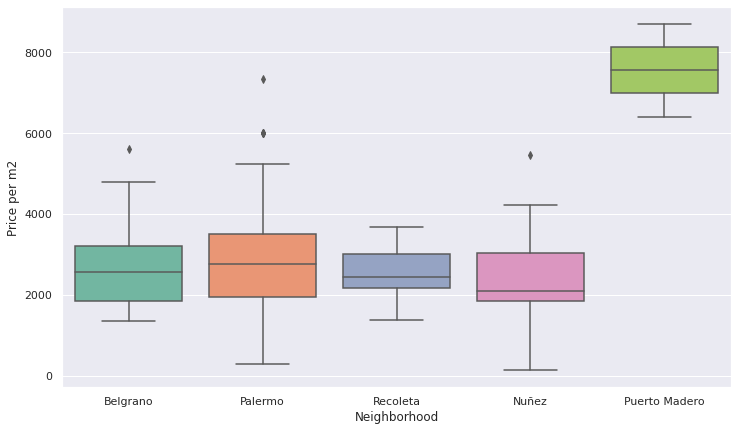

In [ ]:
clean = np.where(
    (data_clean['l3']=='Puerto Madero')|
     (data_clean['l3']=='Palermo')|
    (data_clean['l3']=='Recoleta')|
    (data_clean['l3']=='Belgrano')|
    (data_clean['l3']=='Nuñez')
                )
data_boxplot= data_clean.iloc[clean].copy()
remove_unused_categories(data_clean)
fig, ax=plt.subplots(figsize =(12, 7))
sns.boxplot(data=data_boxplot, x='l3', y='Price_per_m2')
plt.xlabel("Neighborhood")
plt.ylabel("Price per m2")
plt.show()

Puerto Madero has, by far, the most expensive properties in Capital Federal.
Villa Devoto has more properties on sale than the rest of the neighborhoods

# Price Analysis 💲

<function matplotlib.pyplot.show>

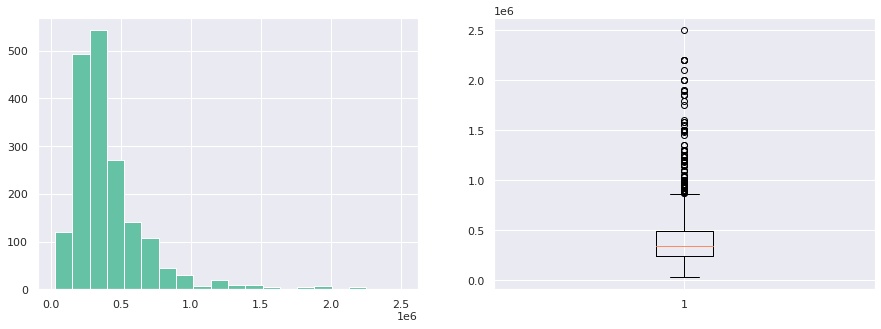

In [ ]:
#Histogram and boxplot for price
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(data_clean['price'], bins=20)
plt.subplot(122)
plt.boxplot(data_clean['price'])
plt.show

We can se that there are a lot of outliers. We will have to work with them later.

# Properties Features 🛌 🛁 👪

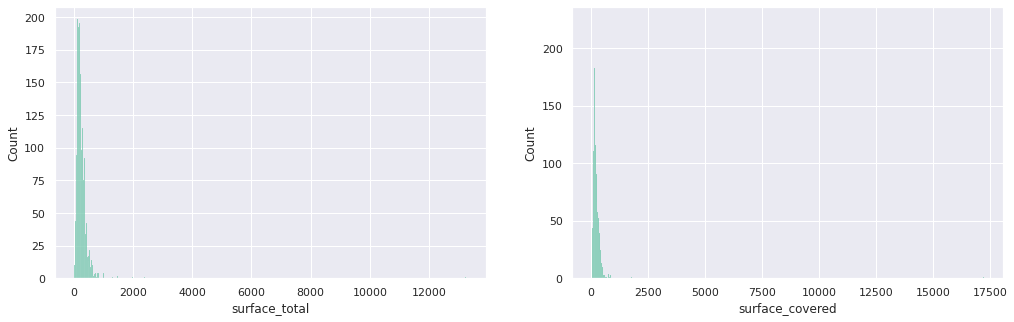

In [ ]:
#Boxplot for surface total and covered
plt.figure(figsize=(17,5))
plt.subplot(121)
sns.histplot(data_clean['surface_total'])
plt.subplot(122)
sns.histplot(data_clean['surface_covered'])

Of couse total surface is bigger than surface covered. Dataset has many outliers.

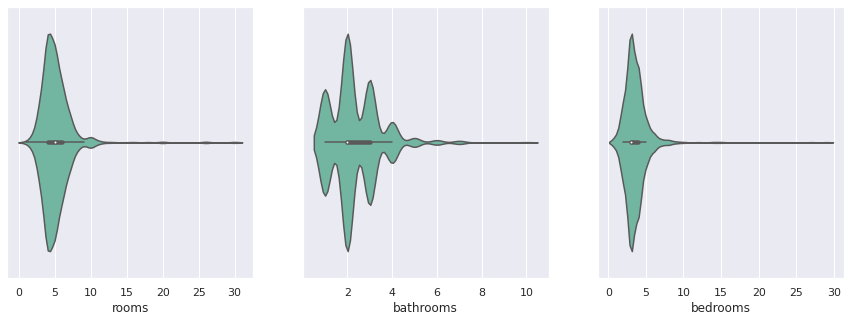

In [ ]:
plt.figure(figsize=(15,5))
varstolook = ["rooms", "bathrooms", 'bedrooms']
for i,var in enumerate(varstolook):
    plt.subplot(1,3,i+1)
    sns.violinplot(x=var, data=data_clean)       

Most common propertie has around 4 rooms, 2 bathrooms, and 3 bedrooms.

# Price per m2 vs Features 💵 

surface_total and surface_covered have highly skewed distributions.
The other variables look almost normally distributed except bathrooms.

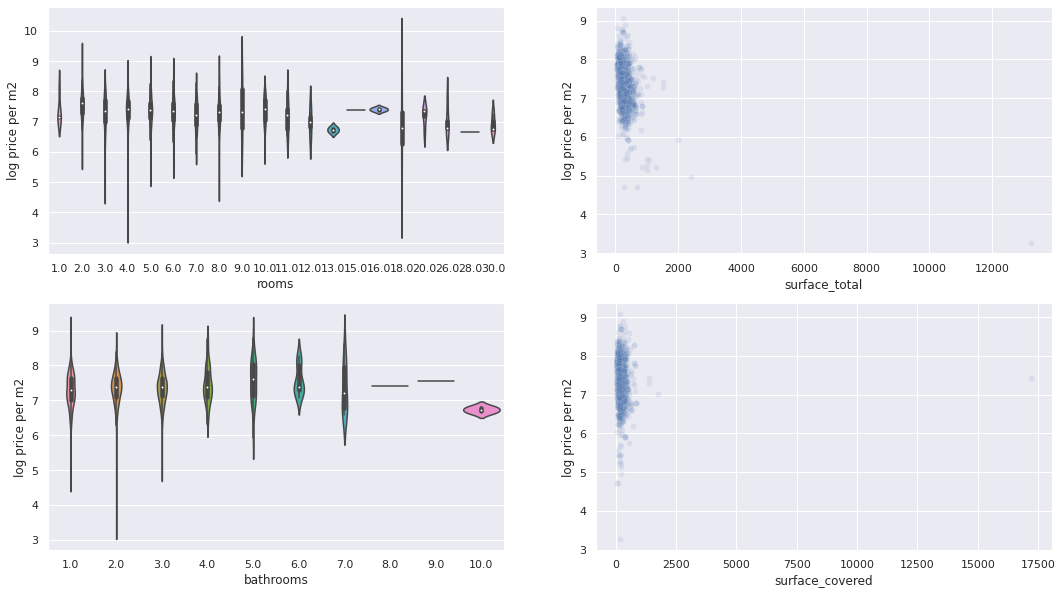

In [ ]:
varstolook = ["rooms", "surface_total", "bathrooms", "surface_covered"]
#Dropping lat and lon columns
data_clean= data_clean.drop(data_clean.columns[0:2], axis=1)
data_clean2=data_clean.copy()
data_clean2['log price per m2']=np.log(data_clean["price"] / data_clean["surface_total"])

plt.figure(figsize=(18,10))
for i,var in enumerate(varstolook):
    plt.subplot(2,2,i+1)
    if var in ['rooms', "bathrooms", "l3"]:
        sns.violinplot(x=var, y='log price per m2', data=data_clean2)
    else:
        sns.scatterplot(x=var,y='log price per m2',data=data_clean2, alpha=0.10,color='b')


Mayor cantidad de baños no implica mayor precio de la propiedad.
Mayor superficie total y edificada no implica mayor precio de la propiedad.
La mayoria de las propiedades mas costosas tienen 1 o 2 habitaciones.
Distritos mas costosos: 6, 16 y 20.


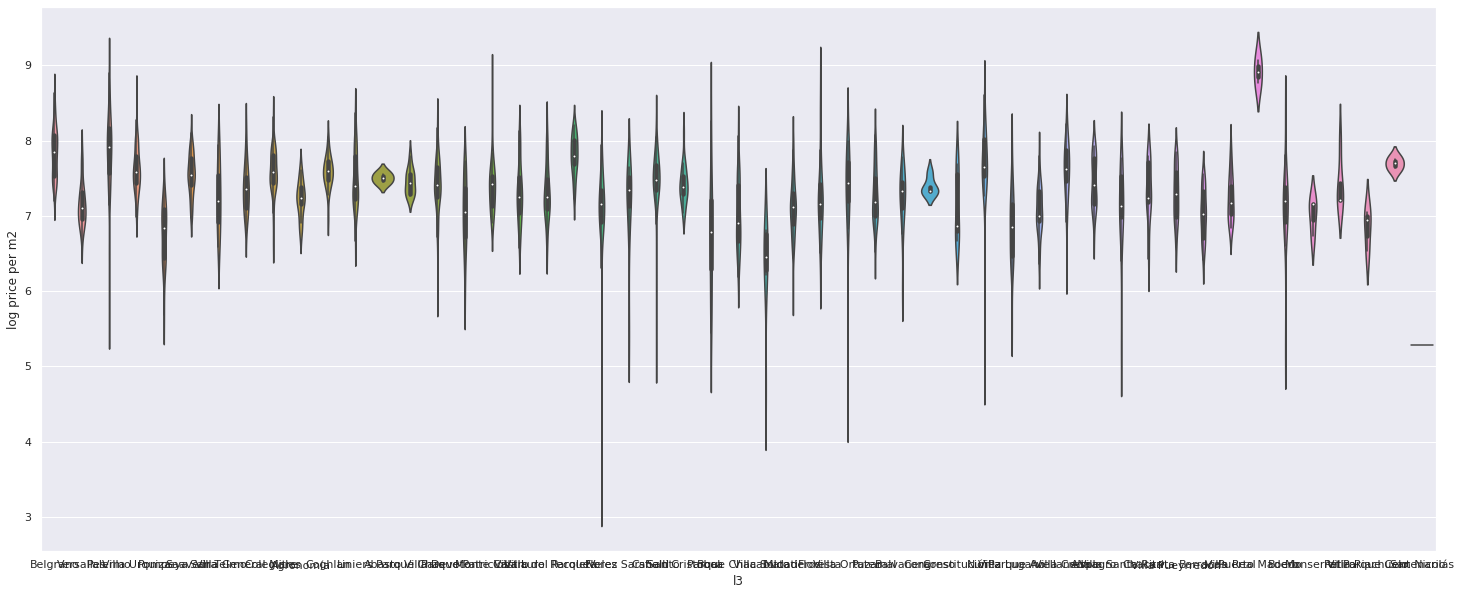

In [ ]:
#log(pricer per m2) vs l3 can't be seen clearly
plt.figure(figsize=(25,10))
sns.violinplot(x='l3', y='log price per m2', data=data_clean2)

**Hypotesis**
Mayor cantidad de baños no implica mayor precio de la propiedad. 
Mayor superficie total y edificada no implica mayor precio de la propiedad. 
2, 9 y 18 habitaciones tienen mayor influencia en el precio por m2.


In [ ]:
#Transfm property_type and l3 in categories
data_clean2['property_type'] = data_clean2['property_type'].astype('category')
data_clean2['l3'] = data_clean2['l3'].astype('category')

In [ ]:
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
data_clean['property_type'] = labelencoder.fit_transform(data_clean['property_type'])
data_clean['l3'] = labelencoder.fit_transform(data_clean['l3'])

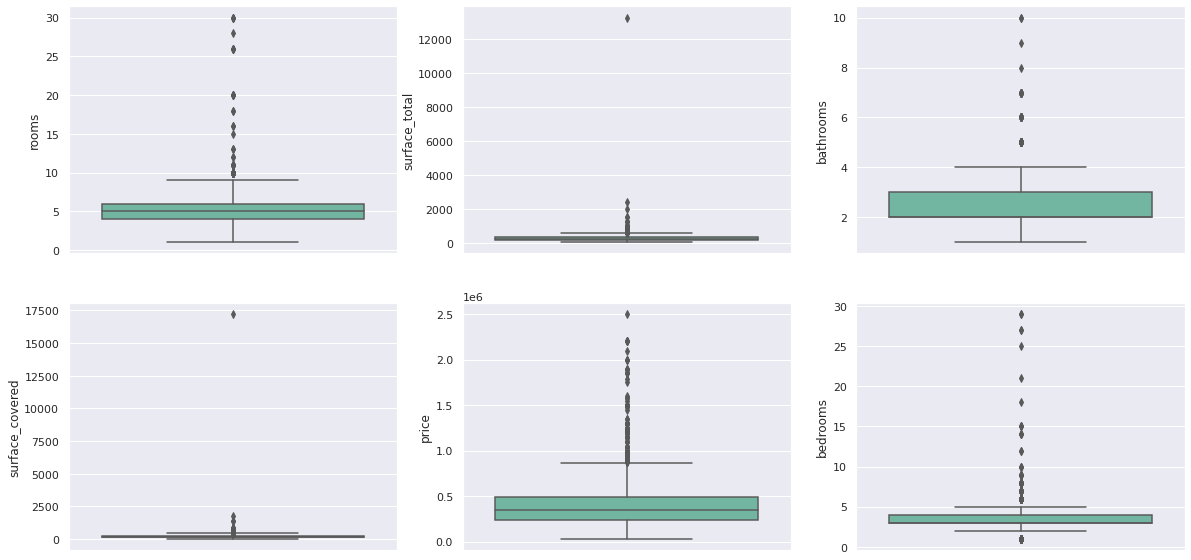

In [ ]:
varstolook = ["rooms", "surface_total", "bathrooms", "surface_covered", "price", "bedrooms"]
def outlier_check(df):
    fig, axs = plt.subplots(ncols=4, nrows=3, figsize=[20, 10])
    axs = axs.flatten()
    index = 0
    for i,var in enumerate(varstolook):
      plt.subplot(2,3,i+1)
      sns.boxplot(y=var, data=data_clean)
outlier_check(df)

<function matplotlib.pyplot.show>

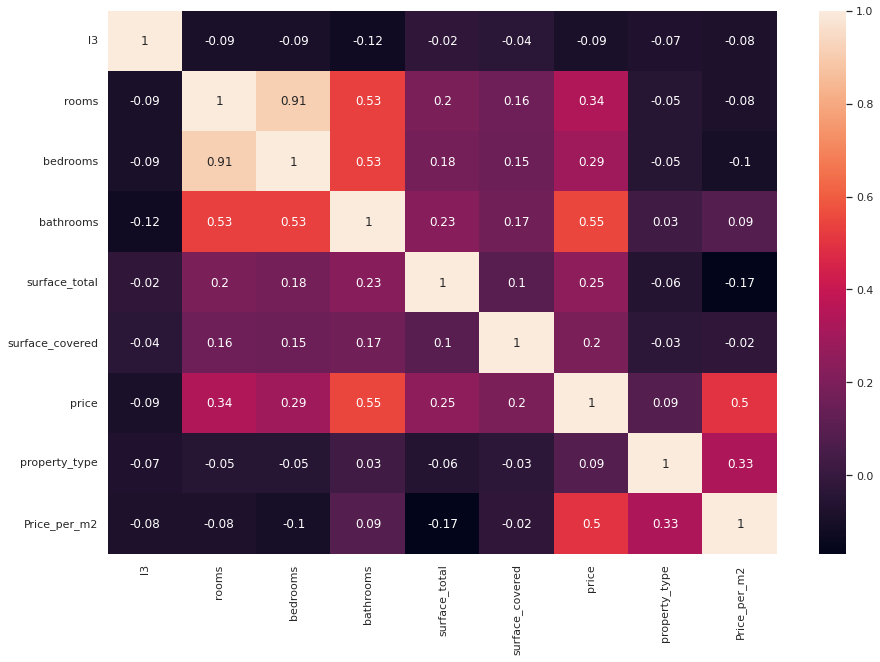

In [ ]:
#Correlation analysis
plt.figure(figsize = (15,10))
sns.heatmap(data_clean.corr().round(2), annot=True)
plt.show

From above correlation plot, we see rooms, price and bathrooms are correlated features.